<a href="https://colab.research.google.com/github/ViswanathKasi9014/viswanath/blob/main/codealpha_task4_Heart_Disease_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-disease:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F863468%2F1471761%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T171158Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7193d34a9513b24e11b62a311c61daa14218bfa29edd3614c0aed9d94b218271bc59b2ae86528f9de6e458d21ec6cae878702a05fe23b79f0a784573ac365644d710544ba5b0627da03a4aadf1de877a582c4a7915ea4a0576d1299ad7cb000abdd2daa6145f9a17c4a6ef951cf3736a190519349f300a53e6c7d5f46d14c3aa1a09584a9efb3769e88faeb452b0607e1ee564596b7ce31f381f36982e54c2aab642560459abad42632982e77e01a45a5d63f36a2241453d9b2f93738ddc3765f7acb3d289cbf0336ec67dce51bb2e4cefa86537749118feb5a065a825ac2f9f44222c518672266d007d27a3b993b7177dd6619b66b12fb4392c8437252f2944'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3478 bytes downloaded
Downloaded and uncompressed: heart-disease
Data source import complete.


In [37]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from scipy.stats import uniform

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease/heart.csv


In [38]:
data = pd.read_csv('/kaggle/input/heart-disease/heart.csv')
print('Shape of the data is ', data.shape)

Shape of the data is  (303, 14)


In [39]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [40]:
data.dtypes

,0
age,int64
sex,int64
cp,int64
trestbps,int64
chol,int64
fbs,int64
restecg,int64
thalach,int64
exang,int64
oldpeak,float64


In [41]:
data = data[data['ca'] < 4] #drop the wrong ca values
data = data[data['thal'] > 0] # drop the wong thal value
print(f'The length of the data now is {len(data)} instead of 303!')

The length of the data now is 296 instead of 303!


In [42]:
data = data.rename(
    columns = {'cp':'chest_pain_type',
               'trestbps':'resting_blood_pressure',
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram',
               'thalach': 'max_heart_rate_achieved',
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression',
               'slope': 'st_slope',
               'ca':'num_major_vessels',
               'thal': 'thalassemia'},
    errors="raise")

In [43]:
data['sex'][data['sex'] == 0] = 'female'
data['sex'][data['sex'] == 1] = 'male'

data['chest_pain_type'][data['chest_pain_type'] == 0] = 'typical angina'
data['chest_pain_type'][data['chest_pain_type'] == 1] = 'atypical angina'
data['chest_pain_type'][data['chest_pain_type'] == 2] = 'non-anginal pain'
data['chest_pain_type'][data['chest_pain_type'] == 3] = 'asymptomatic'

data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 0] = 'normal'
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 1] = 'ST-T wave abnormality'
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 2] = 'left ventricular hypertrophy'

data['exercise_induced_angina'][data['exercise_induced_angina'] == 0] = 'no'
data['exercise_induced_angina'][data['exercise_induced_angina'] == 1] = 'yes'

data['st_slope'][data['st_slope'] == 0] = 'upsloping'
data['st_slope'][data['st_slope'] == 1] = 'flat'
data['st_slope'][data['st_slope'] == 2] = 'downsloping'

data['thalassemia'][data['thalassemia'] == 1] = 'fixed defect'
data['thalassemia'][data['thalassemia'] == 2] = 'normal'
data['thalassemia'][data['thalassemia'] == 3] = 'reversable defect'

In [44]:
data.dtypes

,0
age,int64
sex,object
chest_pain_type,object
resting_blood_pressure,int64
cholesterol,int64
fasting_blood_sugar,object
resting_electrocardiogram,object
max_heart_rate_achieved,int64
exercise_induced_angina,object
st_depression,float64


In [45]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,asymptomatic,145,233,greater than 120mg/ml,normal,150,no,2.3,upsloping,0,fixed defect,1
1,37,male,non-anginal pain,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,upsloping,0,normal,1
2,41,female,atypical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,downsloping,0,normal,1
3,56,male,atypical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,downsloping,0,normal,1
4,57,female,typical angina,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,downsloping,0,normal,1


In [46]:
# numerical fearures 6
num_feats = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
# categorical (binary)
bin_feats = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']
# caterorical (multi-)
nom_feats= ['chest_pain_type', 'resting_electrocardiogram', 'st_slope', 'thalassemia']
cat_feats = nom_feats + bin_feats

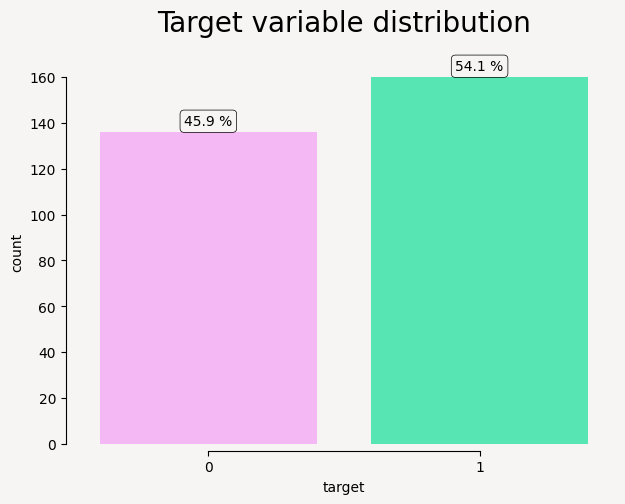

In [47]:
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

plt.figure(figsize=(7, 5),facecolor='#F6F5F4')
total = float(len(data))
ax = sns.countplot(x=data['target'], palette=mypal[1::4])
ax.set_facecolor('#F6F5F4')

for p in ax.patches:

    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Target variable distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

In [48]:
data[num_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
cholesterol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
resting_blood_pressure,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
max_heart_rate_achieved,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
st_depression,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2
num_major_vessels,296.0,0.679054,0.939726,0.0,0.0,0.0,1.00,3.0


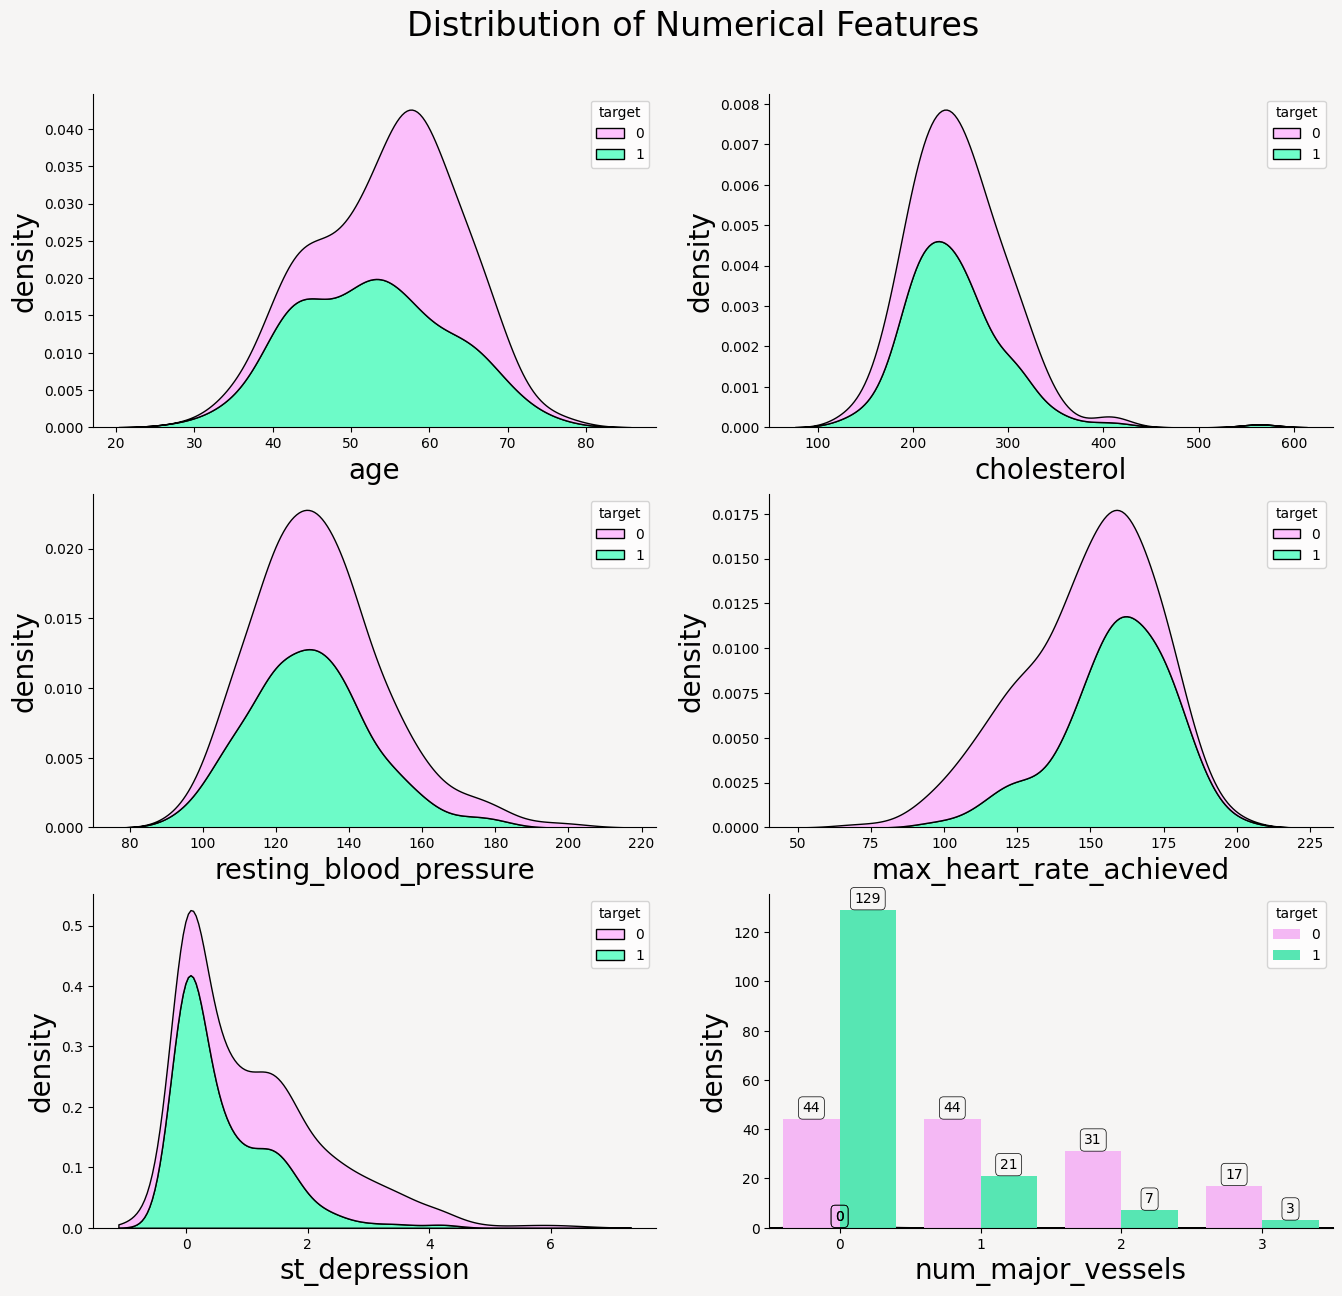

In [49]:
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))
#remove_last= (nrow * ncol) - L

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')

    ax = sns.kdeplot(data=data, x=col, hue="target", multiple="stack", palette=mypal[1::4])
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)

    if col == 'num_major_vessels':
        sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    i = i +1
plt.suptitle('Distribution of Numerical Features' ,fontsize = 24);

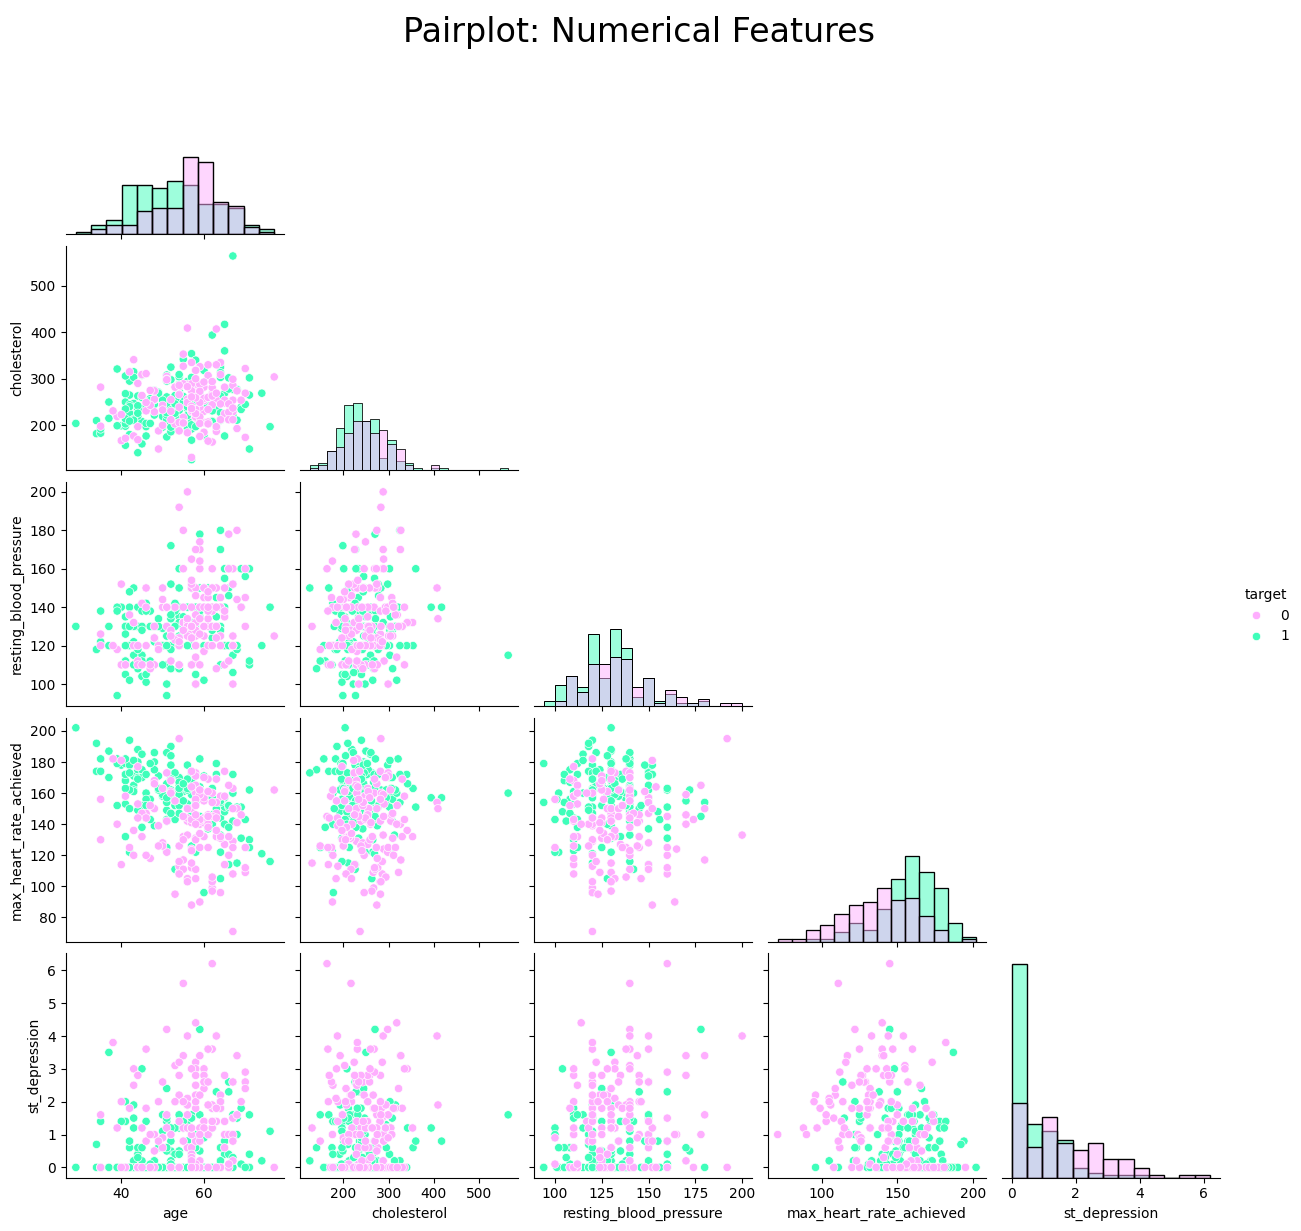

In [50]:
_ = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'target']
data_ = data[_]
g = sns.pairplot(data_, hue="target", corner=True, diag_kind='hist', palette=mypal[1::4]);
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 24);

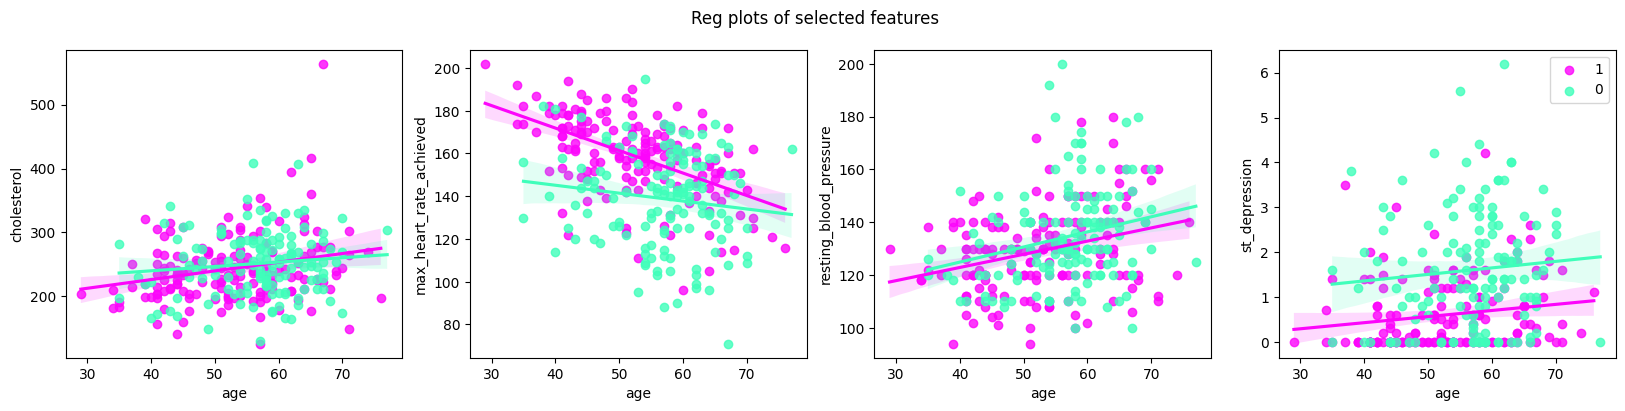

In [51]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))
sns.regplot(data=data[data['target'] ==1], x='age', y='cholesterol', ax = ax[0], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='cholesterol', ax = ax[0], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='st_depression', ax = ax[3], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='st_depression', ax = ax[3], color=mypal[5], label='0')
plt.suptitle('Reg plots of selected features')
plt.legend();

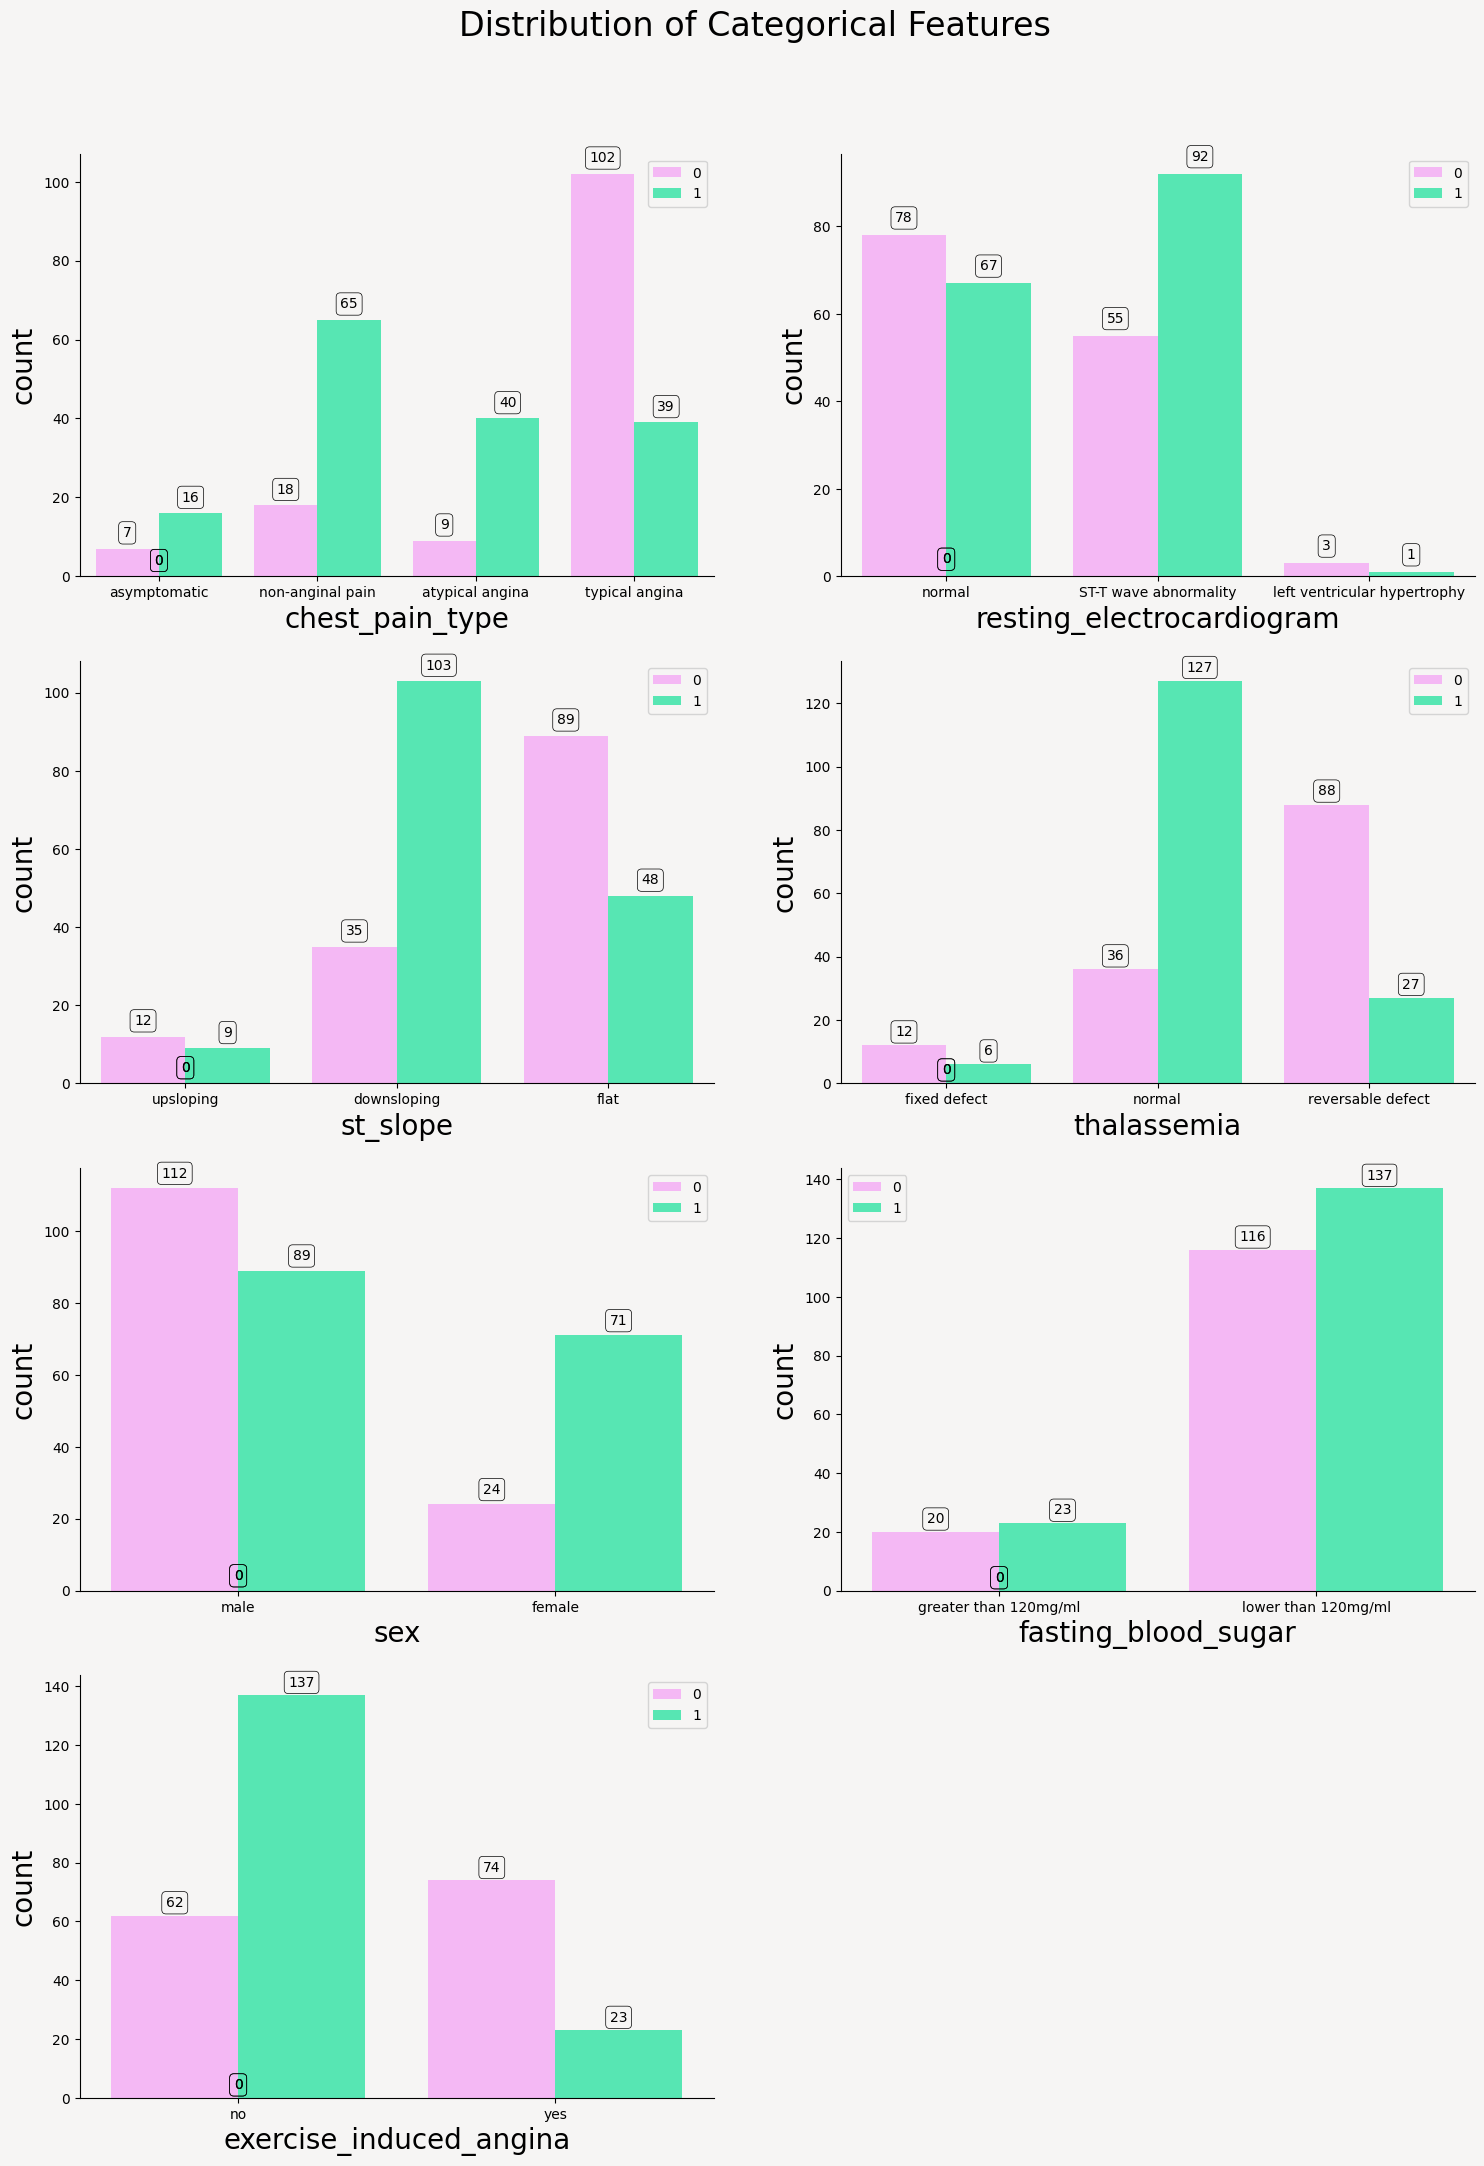

In [52]:
def count_plot(data, cat_feats):
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='#F6F5F4')
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        ax = sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False)
        plt.legend(facecolor='#F6F5F4')

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                  bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

        i = i +1

    plt.suptitle('Distribution of Categorical Features' ,fontsize = 24)
    return 0

count_plot(data, cat_feats[0:-1]);

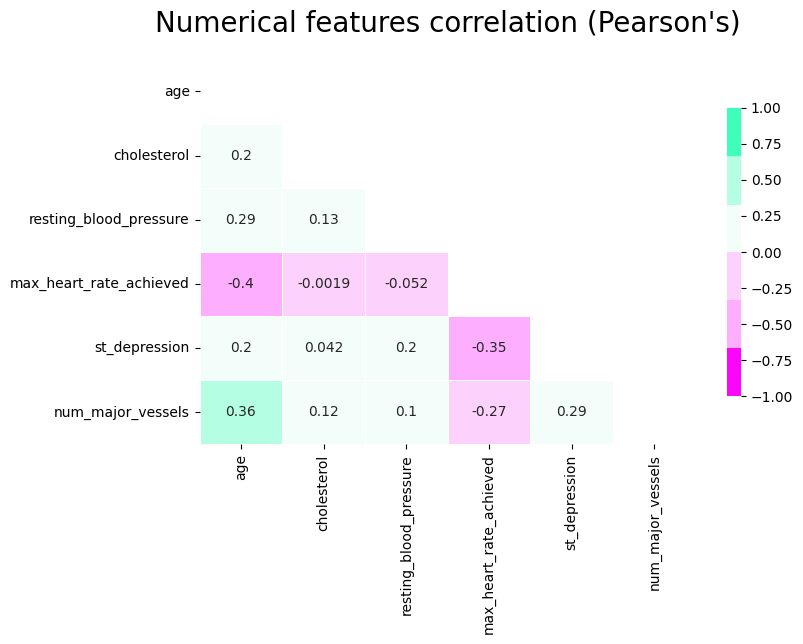

In [53]:
df_ = data[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=20, y= 1.05);

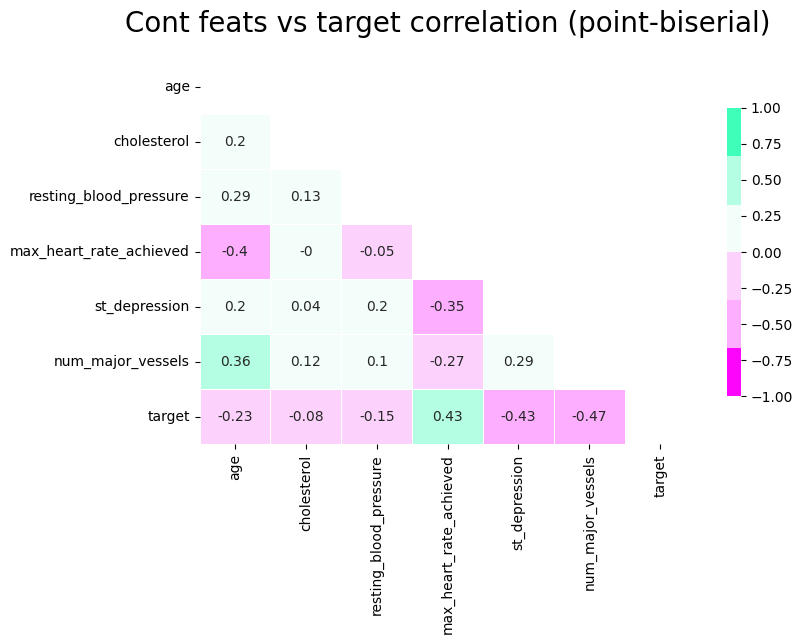

In [54]:
feats_ = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels', 'target']

def point_biserial(x, y):
    pb = stats.pointbiserialr(x, y)
    return pb[0]

rows= []
for x in feats_:
    col = []
    for y in feats_ :
        pbs =point_biserial(data[x], data[y])
        col.append(round(pbs,2))
    rows.append(col)

pbs_results = np.array(rows)
DF = pd.DataFrame(pbs_results, columns = data[feats_].columns, index =data[feats_].columns)

mask = np.triu(np.ones_like(DF, dtype=bool))
corr = DF.mask(mask)

f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Cont feats vs target correlation (point-biserial)", fontsize=20, y= 1.05);

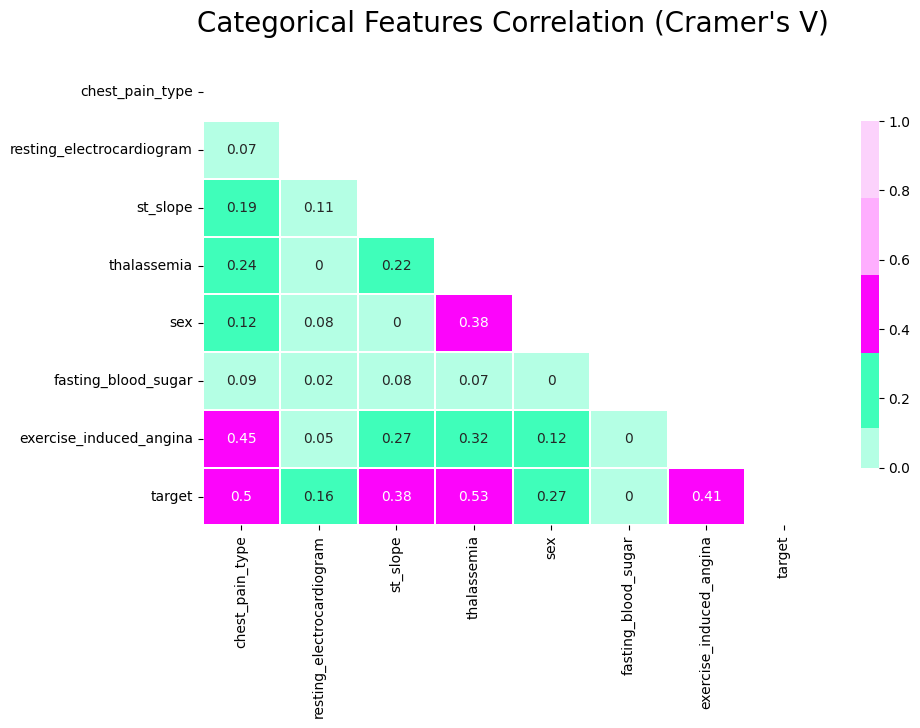

In [55]:
# the cramers_v function is copied from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# calculate the correlation coefficients using the above function
data_ = data[cat_feats]
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y])
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)

# color palette
mypal_1= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA', '#FC05FB', '#FEAEFE', '#FCD2FC']
# plot the heat map
mask = np.triu(np.ones_like(df, dtype=bool))
corr = df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette(mypal_1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y= 1.05);

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import recall_score, accuracy_score,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
import shap

In [56]:
def label_encode_cat_features(data, cat_features):
    '''
    Given a dataframe and its categorical features, this function returns label-encoded dataframe
    '''

    label_encoder = LabelEncoder()
    data_encoded = data.copy()

    for col in cat_features:
        data_encoded[col] = label_encoder.fit_transform(data[col])

    data = data_encoded

    return data


def score_summary(names, classifiers):
    '''
    Given a list of classiers, this function calculates the accuracy,
    ROC_AUC and Recall and returns the values in a dataframe
    '''

    cols=["Classifier", "Accuracy", "ROC_AUC", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)

    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)

        pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, pred)

        pred_proba = clf.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)

        # confusion matric, cm
        cm = confusion_matrix(y_val, pred)

        # recall: TP/(TP+FN)
        recall = cm[1,1]/(cm[1,1] +cm[1,0])

        # precision: TP/(TP+FP)
        precision = cm[1,1]/(cm[1,1] +cm[0,1])

        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        df = pd.DataFrame([[name, accuracy*100, roc_auc, recall, precision, f1]], columns=cols)
        data_table = data_table.append(df)

    return(np.round(data_table.reset_index(drop=True), 2))


def plot_conf_matrix(names, classifiers, nrows, ncols, fig_a, fig_b):
    '''
    Plots confusion matrices in a subplots.

    Args:
        names : list of names of the classifier
        classifiers : list of classification algorithms
        nrows, ncols : number of rows and rows in the subplots
        fig_a, fig_b : dimensions of the figure size
    '''

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))

    i = 0
    for clf, ax in zip(classifiers, axes.flatten()):

        clf.fit(X_train, y_train)
        plot_confusion_matrix(clf, X_val, y_val, ax=ax)
        ax.title.set_text(names[i])
        i = i + 1

    plt.tight_layout()
    plt.show()


def roc_auc_curve(names, classifiers):
    '''
    Given a list of classifiers, this function plots the ROC curves

    '''
    plt.figure(figsize=(12, 8))

    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)

        pred_proba = clf.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")
